# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle
import datetime

from engine.utils import *
from engine.vars import *
from engine.predict import *

# Load Data

In [4]:
df_wd_lag = load_df(FEATURED_DATA_DIR + '/train_fin_wd_lag.pkl')
df_wk_lag = load_df(FEATURED_DATA_DIR + '/train_fin_wk_lag.pkl')
df_all_lag = load_df(FEATURED_DATA_DIR + '/train_fin_light_ver.pkl')

# Preprocessed datasets
df_wk_lag_PP = run_preprocess(df_wk_lag)
df_wd_lag_PP = run_preprocess(df_wd_lag)

# Divide data
# WD
_, _, val_wd_lag_x, val_wd_lag_y = divide_train_val(df_wd_lag_PP, 8, drop=[])
_, _, _, top_v_wd_lag_x, top_v_wd_lag_y = divide_top(df_wd_lag_PP, 4004, 2013)
# WK
_, _, val_wk_lag_x, val_wk_lag_y = divide_train_val(df_wk_lag_PP, 8, drop=[])
_, _, _, top_v_wk_lag_x, top_v_wk_lag_y = divide_top(df_wk_lag_PP, 2206, 999)

In [6]:
model_path = MODELS_DIR + 'lgbm_finalmodel_wd_all.bin'
model_wd_all = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wd_top.bin'
model_wd_top = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wk_all.bin'
model_wk_all = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wk_top.bin'
model_wk_top = pickle.load(open(model_path, 'rb'))

In [7]:
val_df = pd.DataFrame({"wd_true":val_wd_lag_y, "wk_true":val_wk_lag_y})
val_wd_sort = val_wd_lag_x.sort_values('mean_sales_origin', ascending=False)
# Predict all observations
pred_val_wd_all = model_wd_all.predict(val_wd_lag_x)
# Mixed DF (Top: 727개)
val_mixed_wd = mixed_df(model_wd_top, val_wd_sort, val_wd_lag_x, pred_val_wd_all, num_top=727)
val_df['wd_predicted'] = val_mixed_wd[TARGET]

val_wk_sort = val_wk_lag_x.sort_values('mean_sales_origin', ascending=False)
# Predict all observations
pred_val_wk_all = model_wk_all.predict(val_wk_lag_x)
# Mixed DF (Top: 727개)
val_mixed_wk = mixed_df(model_wk_top, val_wk_sort, val_wk_lag_x, pred_val_wk_all, num_top=249)
val_df['wk_predicted'] = val_mixed_wk[TARGET]

# val_df.reset_index(drop = True, inplace = True)

In [8]:
val_df.tail()

,wd_true,wk_true,wd_predicted,wk_predicted
25314,10157000.0,NaN,1.184282e+07,NaN
25315,50929000.0,NaN,6.843236e+06,NaN
25316,13765000.0,NaN,6.843236e+06,NaN
25317,104392000.0,NaN,6.866723e+06,NaN
25318,46608000.0,NaN,6.866723e+06,NaN


# Weekend case

## How good are the model's predictions?

In [9]:
df_wk = val_df[['wk_true', 'wk_predicted']]
df_wk.dropna(inplace = True)

# Calculate the difference between the predicted and the actual price
df_wk['diff'] = df_wk['wk_predicted'] - df_wk['wk_true']

# Calculate the absolute difference between the predicted and the actual price
df_wk['abs_diff'] = np.abs(df_wk['diff'])

# Calculate the percentage of the difference from the actual price
df_wk['%diff'] = 100 * (df_wk['diff'] / df_wk['wk_true'])

# Calculate the absolute percentage difference from the actual price
df_wk['abs_%diff'] = np.abs(df_wk['%diff'])

Text(0, 0.5, 'Diff')

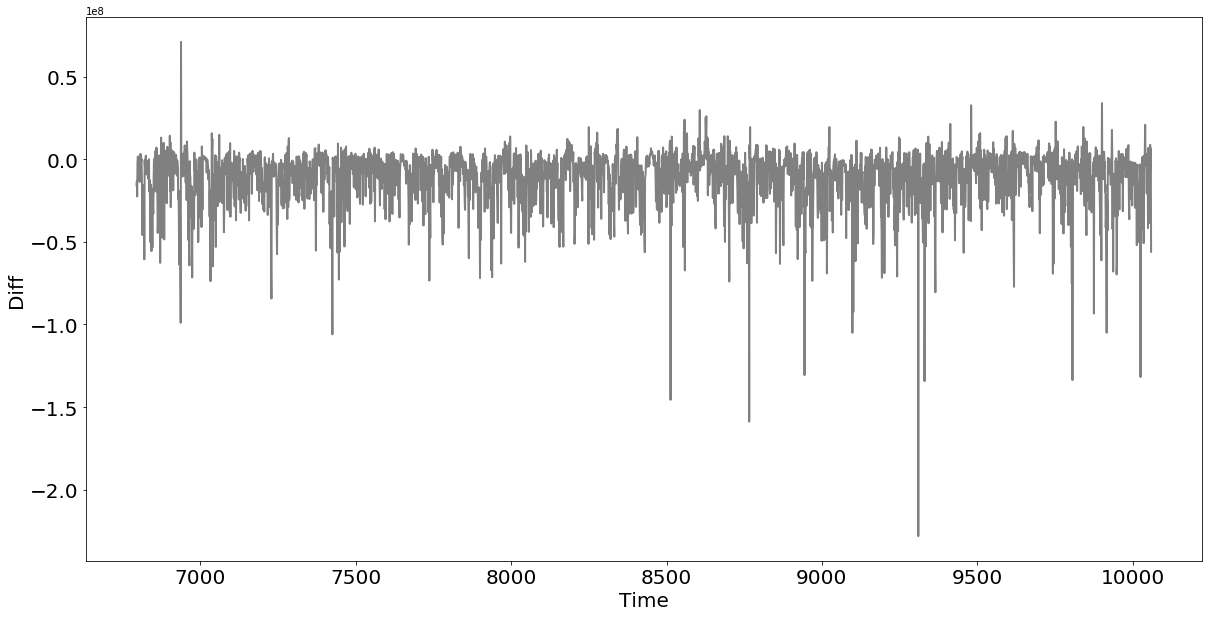

In [10]:
plt.figure(figsize=(20,10))
plt.plot(df_wk['diff'], color='grey', linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in absolute values?

In [11]:
n = 10
# Sort by the 'abs_diff' field and show the n largest mistakes in absolute values
top_missed_wk = df_wk.sort_values("abs_diff", ascending=False).head(n).index
df_wk.sort_values("abs_diff", ascending=False).head(n)

,wk_true,wk_predicted,diff,abs_diff,%diff,abs_%diff
9310,322009000.0,9.378535e+07,-2.282236e+08,2.282236e+08,-70.874928,70.874928
8766,199541000.0,4.069549e+07,-1.588455e+08,1.588455e+08,-79.605450,79.605450
8513,228177000.0,8.253448e+07,-1.456425e+08,1.456425e+08,-63.828745,63.828745
9330,153084000.0,1.878785e+07,-1.342961e+08,1.342961e+08,-87.727096,87.727096
9806,223492000.0,8.981432e+07,-1.336777e+08,1.336777e+08,-59.813182,59.813182
10025,167261000.0,3.543977e+07,-1.318212e+08,1.318212e+08,-78.811693,78.811693
8944,169907000.0,3.926055e+07,-1.306465e+08,1.306465e+08,-76.892919,76.892919
7425,131176000.0,2.515397e+07,-1.060220e+08,1.060220e+08,-80.824258,80.824258
9098,119573000.0,1.455083e+07,-1.050222e+08,1.050222e+08,-87.831003,87.831003
9916,128382000.0,2.340655e+07,-1.049755e+08,1.049755e+08,-81.768046,81.768046


In [12]:
wk_over_mcode = df_wk_lag.loc[top_missed_wk,['마더코드']]
pd.concat([df_wk_lag.loc[top_missed_wk,['방송일시','상품명','판매단가','original_c','취급액']], 
           df_wk.sort_values("abs_diff", ascending=False).head(n)[['diff', '%diff']]], axis = 1)

,방송일시,상품명,판매단가,original_c,취급액,diff,%diff
9310,2019-12-07 01:40:00,코몽트 덤블 플리스 자켓 2종,39900,자켓,322009000.0,-2.282236e+08,-70.874928
8766,2019-11-10 17:00:00,안동간고등어 20팩,30900,간고등어,199541000.0,-1.588455e+08,-79.605450
8513,2019-11-02 17:40:00,멋진밥상 흥양농협 햅쌀 20kg,58900,쌀,228177000.0,-1.456425e+08,-63.828745
9330,2019-12-07 11:00:00,히트융 극세사 퍼융기모 남성 동내의 패키지,69900,내복,153084000.0,-1.342961e+08,-87.727096
9806,2019-12-21 17:40:00,코몽트 덤블 플리스 자켓 2종,39900,자켓,223492000.0,-1.336777e+08,-59.813182
10025,2019-12-29 16:00:00,IH 옛 가마솥 세트,62000,가마솥,167261000.0,-1.318212e+08,-78.811693
8944,2019-11-17 15:40:00,(1등급)221L_딤채김치냉장고,899000,김치냉장고,169907000.0,-1.306465e+08,-76.892919
7425,2019-09-22 10:40:00,아가타 골든 마스터 2종 (펌프스1종+플랫슈즈1종),59900,신발,131176000.0,-1.060220e+08,-80.824258
9098,2019-11-24 17:00:00,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),218000,밥솥,119573000.0,-1.050222e+08,-87.831003
9916,2019-12-28 09:00:00,셀렉프로 뚝배기 전기밥솥(멀티쿠커),79000,멀티쿡,128382000.0,-1.049755e+08,-81.768046


In [13]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df_wk['diff'].mean(), df_wk['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

The mean is very close to 0 (-10656272.06) with std. 16971260.4.


Text(0, 0.5, 'Diff')

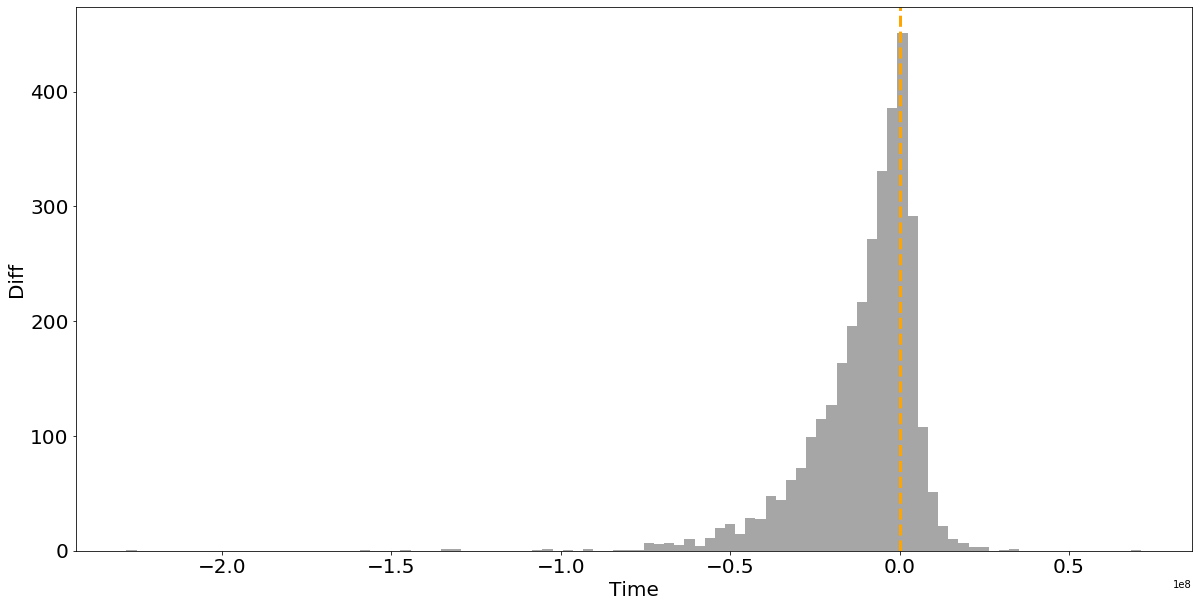

In [14]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df_wk['diff'], color='grey', bins = 100, alpha = 0.7)
plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in percentage?

In [15]:
# Sort by the '%diff' field and show the ㅜ largest proportional mistakes
top_missedp_wk = df_wk.sort_values("abs_%diff", ascending=False).head(n).index
df_wk.sort_values("abs_%diff", ascending=False).head(n)

,wk_true,wk_predicted,diff,abs_diff,%diff,abs_%diff
9413,426000.0,2.195952e+07,2.153352e+07,2.153352e+07,5054.816043,5054.816043
9756,607000.0,1.056052e+07,9.953521e+06,9.953521e+06,1639.789284,1639.789284
8628,1671000.0,2.787778e+07,2.620678e+07,2.620678e+07,1568.329310,1568.329310
8626,1831000.0,2.725855e+07,2.542755e+07,2.542755e+07,1388.724527,1388.724527
6938,5784000.0,7.703004e+07,7.124604e+07,7.124604e+07,1231.778084,1231.778084
9846,1203000.0,1.384766e+07,1.264466e+07,1.264466e+07,1051.094094,1051.094094
7645,319000.0,3.573123e+06,3.254123e+06,3.254123e+06,1020.101276,1020.101276
9758,1102000.0,1.212756e+07,1.102556e+07,1.102556e+07,1000.504614,1000.504614
6902,1531000.0,1.591616e+07,1.438516e+07,1.438516e+07,939.592335,939.592335
8277,1908000.0,1.817345e+07,1.626545e+07,1.626545e+07,852.487057,852.487057


In [16]:
wk_under_mcode = df_wk_lag.loc[top_missedp_wk,['마더코드']]
pd.concat([df_wk_lag.loc[top_missedp_wk,['방송일시','상품명','판매단가','original_c']], 
           df_wk.sort_values("abs_%diff", ascending=False).head(n)[['diff', 'abs_%diff']]], axis = 1).head(10)

,방송일시,상품명,판매단가,original_c,diff,abs_%diff
9413,2019-12-08 01:40:00,오델로 남성 겨울모자 3종,29800,모자,2.153352e+07,5054.816043
9756,2019-12-21 01:40:00,푸마 드라이셀 쉐이핑 레깅스 3종,59000,레깅스,9.953521e+06,1639.789284
8628,2019-11-03 22:40:00,일시불 1+1 국내제조 노비타 뉴스파 비데 무료설치,418000,비데,2.620678e+07,1568.329310
8626,2019-11-03 22:40:00,무이자 1+1 국내제조 노비타 뉴스파 비데 무료설치,458000,비데,2.542755e+07,1388.724527
6938,2019-09-07 10:40:00,피시원 국내산 절단 햇 꽃게 7팩,49900,꽃게,7.124604e+07,1231.778084
9846,2019-12-22 11:20:00,대동모피 패션밍크 후드 롱코트 (19FW),690000,롱코트,1.264466e+07,1051.094094
7645,2019-09-29 10:00:00,뱅뱅 남성 구스다운 2종,89000,구스다운,3.254123e+06,1020.101276
9758,2019-12-21 02:00:00,푸마 드라이셀 쉐이핑 레깅스 3종,59000,레깅스,1.102556e+07,1000.504614
6902,2019-09-01 23:20:00,캐치온 수퍼나인 블랙박스(1CH),99000,블랙박스,1.438516e+07,939.592335
8277,2019-10-20 22:40:00,무이자 1+1 국내제조 노비타 뉴스파 비데 무료설치,458000,비데,1.626545e+07,852.487057


Text(0, 0.5, 'Diff')

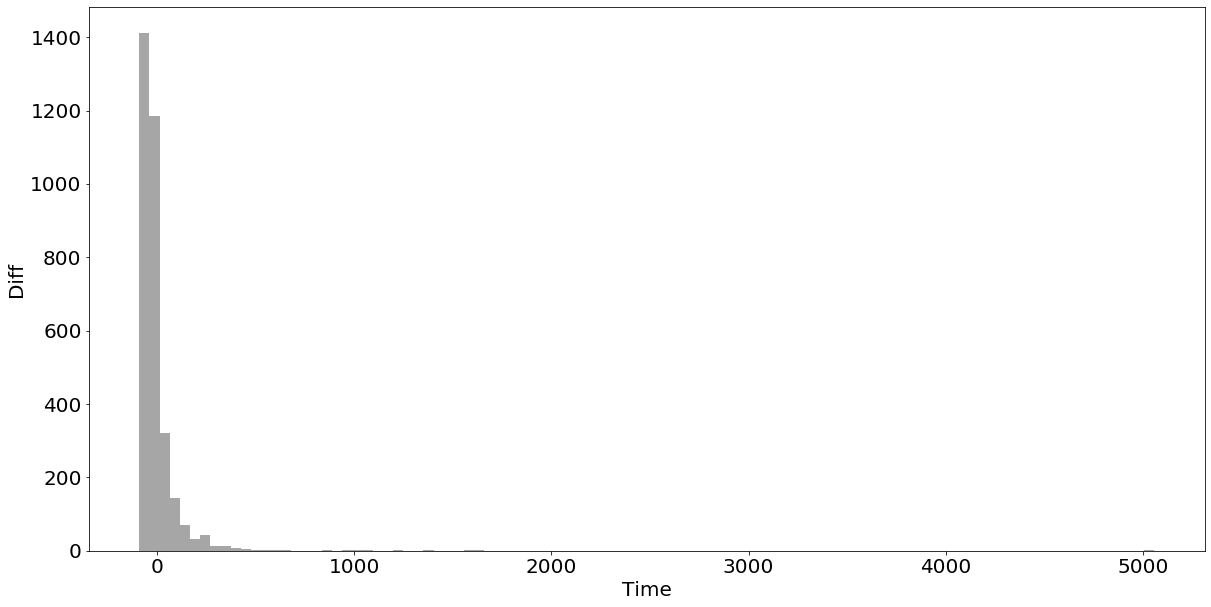

In [17]:
# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df_wk['%diff'], color='grey', bins = 100, alpha = 0.7)
# plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## items(mcode) both over/underestimated 

In [18]:
wk_under_mcode.loc[wk_under_mcode.마더코드.isin(wk_over_mcode.마더코드)].마더코드.unique()

array([], dtype=object)

비데: 파격가/기본 구성으로는 상위 매출 때려버리는데 1+1 붙으면 sales 훅 떨어져서 우리가 상향예측하게 되는 경우 발생 <br/>
꽃게: 약간 9월부터 sales가 (햇꽃게) 올라가기도 하는데 primetime 영향이 커 보임. 5월에는 프라임이어도 잘 매출이 안나옴<br/>
밍크 롱코트: 이거 10분 단위 방송이라 매출 fluctuation이 너무 심하다, 10분안에 주문 못하면 다음 타임에 카운트가 들어가니까<br/>
밥솥: 10인용이 매출이 무조건 더 높음<br/>
온수매트: '점보특대형'이 오히려 많이 팔리고 싱글이 인기가 없다<br/>

In [19]:
y = df_wk_lag.loc[df_wk_lag.마더코드.isin(['100837'])][['상품명', '판매단가','취급액','방송일시']]
y.sort_values(['취급액'], ascending = False).head(5)

,상품명,판매단가,취급액,방송일시
9098,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),218000,119573000.0,2019-11-24 17:00:00
9101,일시불 쿠쿠전기밥솥 10인용 (QS),208000,106986000.0,2019-11-24 17:00:00
9743,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),218000,83504000.0,2019-12-15 22:00:00
9746,일시불 쿠쿠전기밥솥 10인용 (QS),208000,77449000.0,2019-12-15 22:00:00
7464,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),218000,67833000.0,2019-09-22 16:40:00


In [20]:
y.sort_values(['취급액'], ascending = False).tail(5)

,상품명,판매단가,취급액,방송일시
213,(도냄)일시불 쿠쿠전기밥솥 6인용,198000,1458000.0,2019-01-12 12:00:00
3089,무이자 쿠쿠전기밥솥 6인용,208000,826000.0,2019-04-21 15:20:00
7541,일시불 쿠쿠전기밥솥 6인용(QS),198000,814000.0,2019-09-28 08:00:00
6206,일시불 쿠쿠전기밥솥 6인용(QS),198000,810000.0,2019-08-10 14:00:00
8840,일시불 쿠쿠전기밥솥 6인용(QS),198000,798000.0,2019-11-16 11:20:00


# Weekday Case

## How good are the model's predictions?

In [21]:
df_wd = val_df[['wd_true', 'wd_predicted']]
df_wd.dropna(inplace = True)

# Calculate the difference between the predicted and the actual price
df_wd['diff'] = df_wd['wd_predicted'] - df_wd['wd_true']

# Calculate the absolute difference between the predicted and the actual price
df_wd['abs_diff'] = np.abs(df_wd['diff'])

# Calculate the percentage of the difference from the actual price
df_wd['%diff'] = 100 * (df_wd['diff'] / df_wd['wd_true'])

# Calculate the absolute percentage difference from the actual price
df_wd['abs_%diff'] = np.abs(df_wd['%diff'])

Text(0, 0.5, 'Diff')

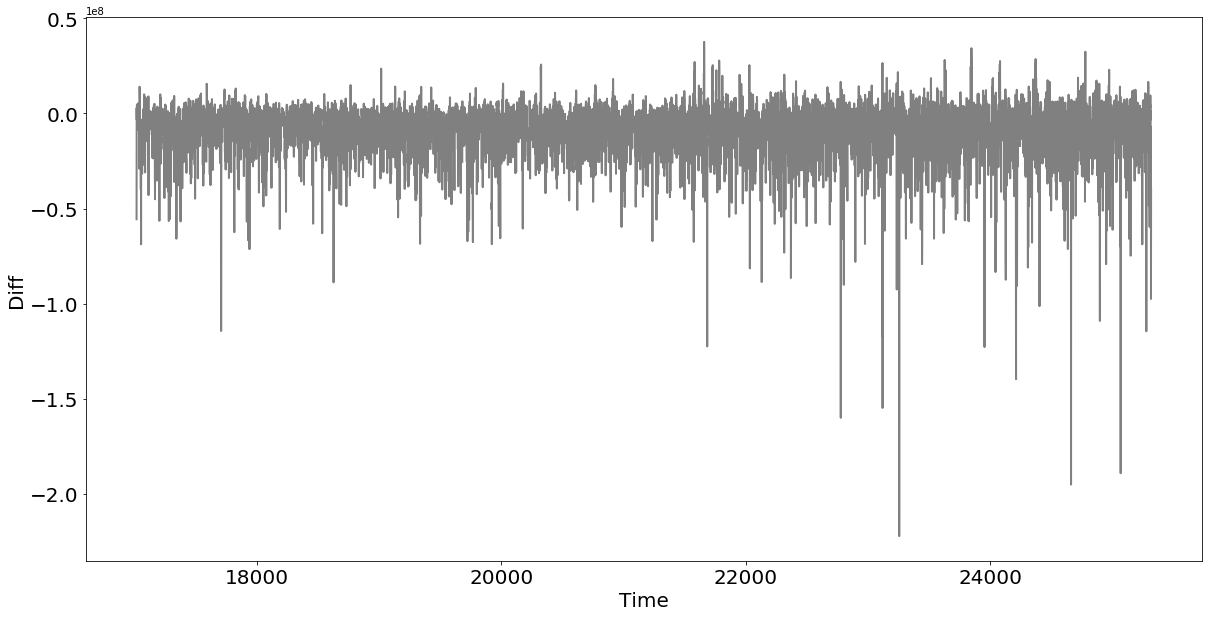

In [22]:
plt.figure(figsize=(20,10))
plt.plot(df_wd['diff'], color='grey', linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in absolute values?

In [23]:
df_wd.loc[df_wd['%diff'] > 0]['%diff'].mean()

108.28008694263617

In [24]:
df_wd.loc[df_wd['%diff'] < 0]['%diff'].mean()

-42.18490348832629

In [25]:
# Sort by the 'abs_diff' field and show the n largest mistakes in absolute values
top_missed_wd = df_wd.sort_values("abs_diff", ascending=False).head(n).index
df_wd.sort_values("abs_diff", ascending=False).head(n)

,wd_true,wd_predicted,diff,abs_diff,%diff,abs_%diff
23257,231789000.0,9.608372e+06,-2.221806e+08,2.221806e+08,-95.854690,95.854690
24663,216065000.0,2.097526e+07,-1.950897e+08,1.950897e+08,-90.292155,90.292155
25069,270284000.0,8.116659e+07,-1.891174e+08,1.891174e+08,-69.969886,69.969886
22779,241079000.0,8.105881e+07,-1.600202e+08,1.600202e+08,-66.376659,66.376659
23121,225084000.0,7.026905e+07,-1.548150e+08,1.548150e+08,-68.780966,68.780966
23258,157780000.0,9.192797e+06,-1.485872e+08,1.485872e+08,-94.173661,94.173661
24213,152770000.0,1.310989e+07,-1.396601e+08,1.396601e+08,-91.418544,91.418544
23955,187419000.0,6.462313e+07,-1.227959e+08,1.227959e+08,-65.519435,65.519435
21686,135711000.0,1.323607e+07,-1.224749e+08,1.224749e+08,-90.246869,90.246869
23117,185927000.0,6.918569e+07,-1.167413e+08,1.167413e+08,-62.788791,62.788791


In [26]:
wd_under_mcode = df_wd_lag.loc[top_missed_wd,['마더코드']]
pd.concat([df_wd_lag.loc[top_missed_wd,['방송일시','마더코드','상품코드','상품명','판매단가','취급액']], 
           df_wd.sort_values("abs_diff", ascending=False).head(n)[['wd_predicted', 'diff', '%diff']]], axis = 1)

,방송일시,마더코드,상품코드,상품명,판매단가,취급액,wd_predicted,diff,%diff
23257,2019-11-29 23:00:00,100148,200412,LG 울트라HD TV 65UM7900BNA,1700000,231789000.0,9.608372e+06,-2.221806e+08,-95.854690
24663,2019-12-20 14:00:00,100558,201655,정직한 농부의 석류,59900,216065000.0,2.097526e+07,-1.950897e+08,-90.292155
25069,2019-12-27 00:00:00,100323,201025,피시원 국내산 햇 손질문어 7팩,49900,270284000.0,8.116659e+07,-1.891174e+08,-69.969886
22779,2019-11-22 19:00:00,100317,201665,국내산 손질 햇 갑오징어 9팩,49900,241079000.0,8.105881e+07,-1.600202e+08,-66.376659
23121,2019-11-28 16:20:00,100255,200869,한일 대용량 스텐 분쇄믹서기,109800,225084000.0,7.026905e+07,-1.548150e+08,-68.780966
23258,2019-11-29 23:00:00,100148,200413,LG 울트라HD TV 75UM7900BNA,2840000,157780000.0,9.192797e+06,-1.485872e+08,-94.173661
24213,2019-12-13 22:00:00,100155,200556,일시불 LG전자 매직스페이스 냉장고,1359000,152770000.0,1.310989e+07,-1.396601e+08,-91.418544
23955,2019-12-11 00:00:00,100418,201322,코몽트 덤블 플리스 자켓 2종,39900,187419000.0,6.462313e+07,-1.227959e+08,-65.519435
21686,2019-11-07 00:00:00,100340,201057,스튜디오럭스 후드롱구스다운코트,59000,135711000.0,1.323607e+07,-1.224749e+08,-90.246869
23117,2019-11-28 15:00:00,100766,202239,참존 탑뉴스 지이링클 기초세트,59000,185927000.0,6.918569e+07,-1.167413e+08,-62.788791


In [27]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df_wd['diff'].mean(), df_wd['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

The mean is very close to 0 (-8495888.99) with std. 14410051.88.


Text(0, 0.5, 'Diff')

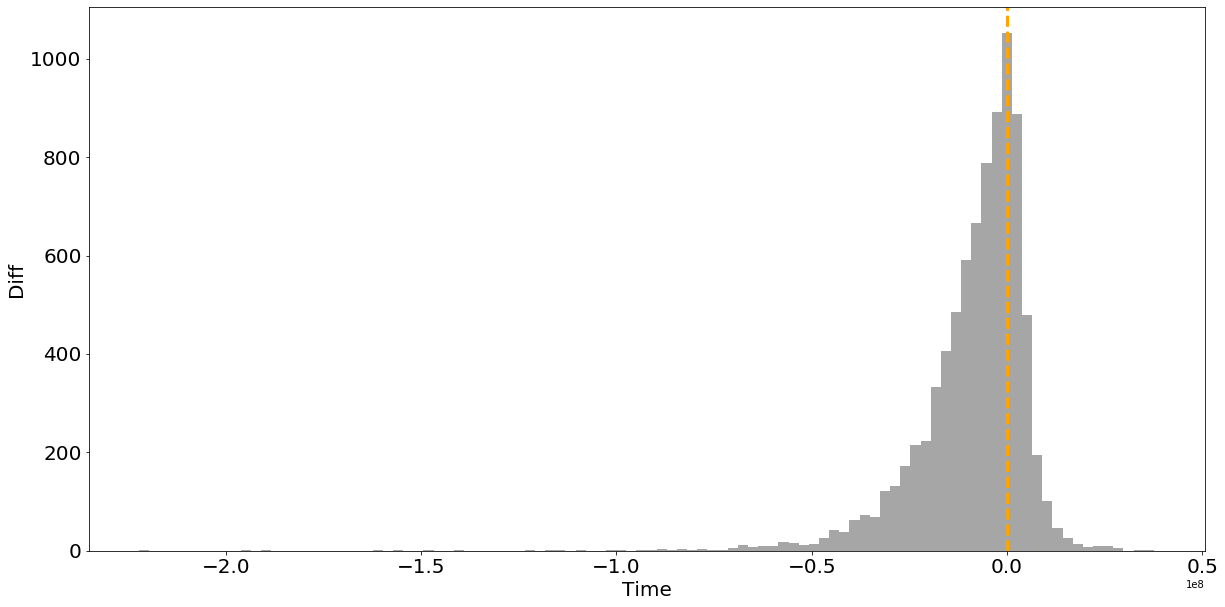

In [28]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df_wd['diff'], color='grey', bins = 100, alpha = 0.7)
plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in percentage?

In [29]:
# Sort by the '%diff' field and show the ㅜ largest proportional mistakes
top_missedp_wd = df_wd.sort_values("abs_%diff", ascending=False).head(n).index
df_wd.sort_values("abs_%diff", ascending=False).head(n)

,wd_true,wd_predicted,diff,abs_diff,%diff,abs_%diff
24463,179000.0,9.149774e+06,8.970774e+06,8.970774e+06,5011.605617,5011.605617
24461,308000.0,1.162669e+07,1.131869e+07,1.131869e+07,3674.899652,3674.899652
20284,181000.0,5.454373e+06,5.273373e+06,5.273373e+06,2913.465883,2913.465883
20286,443000.0,1.095089e+07,1.050789e+07,1.050789e+07,2371.985009,2371.985009
23842,1332000.0,2.595182e+07,2.461982e+07,2.461982e+07,1848.334942,1848.334942
21898,181000.0,3.462721e+06,3.281721e+06,3.281721e+06,1813.105739,1813.105739
19210,400000.0,7.075952e+06,6.675952e+06,6.675952e+06,1668.988070,1668.988070
21761,1671000.0,2.439936e+07,2.272836e+07,2.272836e+07,1360.165442,1360.165442
23012,840000.0,1.226533e+07,1.142533e+07,1.142533e+07,1360.158072,1360.158072
23848,2584000.0,3.688586e+07,3.430186e+07,3.430186e+07,1327.471297,1327.471297


In [30]:
wd_over_mcode = df_wd_lag.loc[top_missedp_wd,['마더코드']]
pd.concat([df_wd_lag.loc[top_missedp_wd,['방송일시','상품명','판매단가','original_c']], 
           df_wd.sort_values("abs_%diff", ascending=False).head(n)[['diff', 'abs_%diff']]], axis = 1).head(10)

,방송일시,상품명,판매단가,original_c,diff,abs_%diff
24463,2019-12-18 14:00:00,1세트 센티멘탈 디퓨저골드,31000,다퓨저,8.970774e+06,5011.605617
24461,2019-12-18 13:40:00,1세트 센티멘탈 디퓨저골드,31000,다퓨저,1.131869e+07,3674.899652
20284,2019-10-16 23:00:00,1세트 센티멘탈 디퓨저골드,31000,다퓨저,5.273373e+06,2913.465883
20286,2019-10-16 23:20:00,1세트 센티멘탈 디퓨저골드,31000,다퓨저,1.050789e+07,2371.985009
23842,2019-12-09 23:20:00,알렉스하운드 양모 퀼팅 패딩 자켓,29900,자켓,2.461982e+07,1848.334942
21898,2019-11-11 01:20:00,1세트 센티멘탈 디퓨저골드,31000,다퓨저,3.281721e+06,1813.105739
19210,2019-10-02 12:00:00,키친아트 스마트뷰 스텐밀폐용기 9종,89000,밀폐용기,6.675952e+06,1668.988070
21761,2019-11-07 19:40:00,일시불 1+1 국내제조 노비타 뉴스파 비데 무료설치,418000,비데,2.272836e+07,1360.165442
23012,2019-11-27 12:40:00,무이자 쿠쿠전기밥솥 6인용(QS),208000,밥솥,1.142533e+07,1360.158072
23848,2019-12-10 00:00:00,알렉스하운드 양모 퀼팅 패딩 자켓,29900,자켓,3.430186e+07,1327.471297


### 상향예측 나오는 이유?
디퓨저골드 같은 경우 같은 마더코드 공유하는 5세트 제품이 취급액이 높음<br/>
우리 모델로는 5세트와 1세트간에 features 차이가 판매단가말고는 없어서 detect가 안되는 듯

In [45]:
df_wd_lag[df_wd_lag.마더코드 == "100395"][['상품코드','방송일시','상품명','original_c','판매단가','취급액']].head(6)

,상품코드,방송일시,상품명,original_c,판매단가,취급액
20284,201272,2019-10-16 23:00:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000,181000.0
20285,201278,2019-10-16 23:00:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000,23923000.0
20286,201272,2019-10-16 23:20:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000,443000.0
20287,201278,2019-10-16 23:20:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000,23506000.0
20288,201278,2019-10-16 23:40:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000,31327000.0
21898,201272,2019-11-11 01:20:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000,181000.0


Text(0, 0.5, 'Diff')

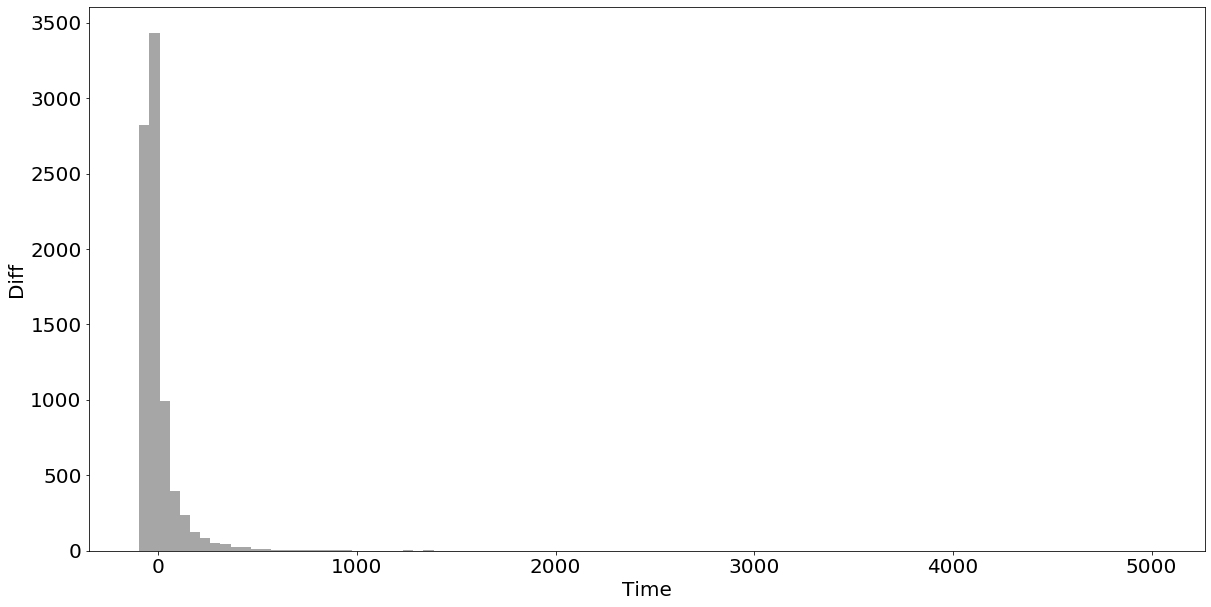

In [32]:
# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df_wd['%diff'], color='grey', bins = 100, alpha = 0.7)
# plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## items(mcode) both over/underestimated 

밥솥: 10인용이 매출이 무조건 더 높다<br/>
김치냉장고: ? <br/>

In [34]:
y = df_wk_lag.loc[df_wk_lag.마더코드.isin(['100091'])][['상품명', '판매단가','취급액','방송일시']]
y.sort_values(['취급액'], ascending = False).head(10)

,상품명,판매단가,취급액,방송일시
8944,(1등급)221L_딤채김치냉장고,899000,169907000.0,2019-11-17 15:40:00
8559,(1등급)467L_딤채김치냉장고,2549000,106446000.0,2019-11-03 09:50:00
9165,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000,86695000.0,2019-11-30 16:20:00
8688,(1등급)221L_딤채김치냉장고,899000,84844000.0,2019-11-09 14:00:00
9166,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000,67485000.0,2019-11-30 16:40:00
8687,(1등급)221L_딤채김치냉장고,899000,65071000.0,2019-11-09 13:40:00
8706,(1등급)467L_딤채김치냉장고,2549000,64150000.0,2019-11-09 21:50:00
8770,(1등급)467L_딤채김치냉장고,2549000,50477000.0,2019-11-10 17:50:00
9164,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000,44709000.0,2019-11-30 16:00:00
8943,(1등급)221L_딤채김치냉장고,899000,40313000.0,2019-11-17 15:20:00


In [35]:
y.sort_values(['취급액'], ascending = False).tail(10)

,상품명,판매단가,취급액,방송일시
9163,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000,25232000.0,2019-11-30 15:40:00
8557,(1등급)467L_딤채김치냉장고,2549000,21845000.0,2019-11-03 09:20:00
8768,(1등급)467L_딤채김치냉장고,2549000,21418000.0,2019-11-10 17:20:00
8704,(1등급)467L_딤채김치냉장고,2549000,20987000.0,2019-11-09 21:20:00
8769,(1등급)221L_딤채김치냉장고,899000,19681000.0,2019-11-10 17:50:00
8558,(1등급)221L_딤채김치냉장고,899000,15134000.0,2019-11-03 09:50:00
8767,(1등급)221L_딤채김치냉장고,899000,12717000.0,2019-11-10 17:20:00
8703,(1등급)221L_딤채김치냉장고,899000,10151000.0,2019-11-09 21:20:00
8686,(1등급)221L_딤채김치냉장고,899000,7445000.0,2019-11-09 13:20:00
8556,(1등급)221L_딤채김치냉장고,899000,5028000.0,2019-11-03 09:20:00


# Then, what makes us to predict wrong?

In [36]:
num_cols = ['판매단가', '취급액',
       'months','parttime', 'min_range','primetime', 'freq',
       'dup_times', 'dup_times_smallc',
       'bpower', 'steady','luxury', 'pay',
       'summer', 'fall', 'winter', 'rain', 'temp_diff_s', 
       'mean_sales_origin']
cat_cols = ['상품군','big_c','middle_c','small_c','original_c']

In [37]:
# 전체 wk
df_wk_lag[num_cols].describe() #.iloc[~df_wk_lag.index.isin(top_missed_wk)]

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,1.006000e+04,1.006000e+04,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,1.006000e+04
mean,4.503309e+05,2.581054e+07,6.466899,0.506759,0.689165,3.087972,1.306362,0.336183,0.531710,0.259940,0.231412,0.099006,0.358449,0.074652,9.209473,2.331392e+07
std,6.798072e+05,2.302324e+07,3.393414,0.786514,0.462858,1.703407,0.711612,0.472426,0.499018,0.438623,0.421756,0.298685,0.479569,0.262842,3.037940,1.398198e+07
min,2.900000e+04,2.680000e+05,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000,2.372600e+06
25%,5.990000e+04,8.555250e+06,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.900000,1.232607e+07
50%,1.190000e+05,1.851500e+07,6.000000,0.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.400000,1.841857e+07
75%,5.090000e+05,3.671600e+07,9.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,11.000000,3.123914e+07
max,5.060000e+06,3.220090e+08,12.000000,2.000000,1.000000,9.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.400000,1.172547e+08


In [38]:
df_wk_lag.iloc[top_missed_wk][num_cols].describe() #하향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,10.00000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,1.000000e+01
mean,155740.00000,1.842602e+08,11.300000,1.300000,0.300000,2.700000,1.200000,0.100000,0.800000,0.100000,0.100000,0.200000,0.500000,0.200000,7.25000,4.070221e+07
std,266529.66981,6.170516e+07,0.948683,0.948683,0.483046,0.674949,0.421637,0.316228,0.421637,0.316228,0.316228,0.421637,0.527046,0.421637,2.77058,1.635951e+07
min,30900.00000,1.195730e+08,9.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.30000,1.549914e+07
25%,44650.00000,1.366530e+08,11.000000,0.250000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.47500,2.631182e+07
50%,60950.00000,1.685840e+08,11.500000,2.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,6.70000,4.643509e+07
75%,76725.00000,2.175042e+08,12.000000,2.000000,0.750000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.55000,5.389816e+07
max,899000.00000,3.220090e+08,12.000000,2.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.00000,6.251175e+07


#### 취급액이 유독 하향예측된 상품들의 공통점?
판매단가가 오히려 평균 대비 낮고, primetime 에 속함. freq/bpower 는 오히려 낮은 경향이 있고 겨울 계절상품인 경우가 많다


In [39]:
df_wk_lag.iloc[top_missedp_wk][num_cols].describe() #우리가 상향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,10.000000,1.000000e+01,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,1.000000e+01
mean,240970.000000,1.638200e+06,10.700000,0.0,0.600000,3.500000,1.100000,0.300000,0.600000,0.100000,0.100000,0.300000,0.800000,0.0,9.420000,3.026283e+07
std,239849.175062,1.565609e+06,1.337494,0.0,0.516398,1.715938,0.316228,0.483046,0.516398,0.316228,0.316228,0.483046,0.421637,0.0,2.379916,2.079052e+07
min,29800.000000,3.190000e+05,9.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.600000,4.626708e+06
25%,59000.000000,7.307500e+05,9.250000,0.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,7.200000,1.832024e+07
50%,94000.000000,1.367000e+06,11.000000,0.0,1.000000,3.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.500000,2.696549e+07
75%,448000.000000,1.791000e+06,12.000000,0.0,1.000000,5.000000,1.000000,0.750000,1.000000,0.000000,0.000000,0.750000,1.000000,0.0,10.850000,3.528816e+07
max,690000.000000,5.784000e+06,12.000000,0.0,1.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,12.700000,8.149775e+07


In [40]:
# 하향
df_wk_lag.iloc[top_missed_wk][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
8944,가전,디지털/가전,주방가전,김치냉장고,김치냉장고
8766,농수축,식품,수산,생선,간고등어
8513,농수축,식품,농산물,쌀,쌀
9330,속옷,패션의류,남성언더웨어/잠옷,시즌성내의,내복
9310,의류,패션의류,여성의류,재킷,자켓
9806,의류,패션의류,여성의류,재킷,자켓
7425,잡화,패션잡화,여성신발,힐/펌프스,신발
10025,주방,생활/건강,주방용품,냄비/솥,가마솥
9098,주방,디지털/가전,주방가전,전기밥솥,밥솥
9916,주방,디지털/가전,주방가전,전기쿠커,멀티쿡


In [41]:
# 상향
df_wk_lag.iloc[top_missedp_wk][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
6938,농수축,식품,수산,해산물/어패류,꽃게
8628,생활용품,생활/건강,욕실용품,비데/비데용품,비데
8626,생활용품,생활/건강,욕실용품,비데/비데용품,비데
6902,생활용품,디지털/가전,자동차기기,블랙박스/액세서리,블랙박스
8277,생활용품,생활/건강,욕실용품,비데/비데용품,비데
9756,속옷,패션의류,여성의류,레깅스,레깅스
9758,속옷,패션의류,여성의류,레깅스,레깅스
9846,의류,패션의류,여성의류,코트,롱코트
7645,의류,패션의류,남성의류,점퍼,구스다운
9413,잡화,패션잡화,모자,비니,모자


In [42]:
# 전체 wd
df_wd_lag[num_cols].describe() #.iloc[~df_wd_lag.index.isin(top_missed_wd)]

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,2.531900e+04,2.531900e+04,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,2.531900e+04
mean,3.630370e+05,2.202639e+07,6.502390,0.347842,0.632766,2.985584,1.198191,0.270903,0.457996,0.208855,0.205735,0.103875,0.330108,0.125360,9.351420,2.301837e+07
std,6.021002e+05,1.864156e+07,3.396789,0.662003,0.482061,1.583145,0.514175,0.444435,0.498242,0.406499,0.404246,0.305104,0.470261,0.331134,2.871092,1.358430e+07
min,1.280000e+04,1.030000e+05,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000,1.159000e+06
25%,5.900000e+04,7.773500e+06,4.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000,1.232607e+07
50%,9.600000e+04,1.689700e+07,7.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.300000,1.848124e+07
75%,2.590000e+05,3.151050e+07,9.000000,0.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.200000,3.096592e+07
max,7.930000e+06,2.702840e+08,12.000000,2.000000,1.000000,10.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.500000,9.958071e+07


In [43]:
df_wd_lag.iloc[top_missed_wd][num_cols].describe() #하향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.0,10.00000,1.000000e+01
mean,6.326400e+05,2.003908e+08,11.400000,0.200000,0.700000,2.400000,1.300000,0.300000,0.800000,0.300000,0.0,0.100000,0.700000,0.0,9.75000,4.406125e+07
std,9.904727e+05,4.349487e+07,0.516398,0.632456,0.483046,0.699206,0.483046,0.483046,0.421637,0.483046,0.0,0.316228,0.483046,0.0,2.36514,1.810787e+07
min,3.990000e+04,1.357110e+08,11.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,5.50000,1.735513e+07
25%,5.217500e+04,1.648168e+08,11.000000,0.000000,0.250000,2.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.250000,0.0,8.85000,3.052635e+07
50%,5.945000e+04,2.017420e+08,11.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,10.00000,5.035016e+07
75%,1.046700e+06,2.301128e+08,12.000000,0.000000,1.000000,2.750000,1.750000,0.750000,1.000000,0.750000,0.0,0.000000,1.000000,0.0,10.82500,5.686967e+07
max,2.840000e+06,2.702840e+08,12.000000,2.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,14.30000,6.561081e+07


#### 취급액이 유독 상향예측된 상품들의 공통점?

In [44]:
df_wd_lag.iloc[top_missedp_wd][num_cols].describe() #우리가 상향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,10.000000,1.000000e+01,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.000000,10.000000,1.000000e+01
mean,92980.000000,8.119000e+05,11.100000,0.0,0.200000,4.000000,1.100000,0.100000,0.200000,0.0,0.0,0.100000,0.400000,0.100000,7.800000,2.493214e+07
std,127387.953381,8.100741e+05,0.875595,0.0,0.421637,1.885618,0.316228,0.316228,0.421637,0.0,0.0,0.316228,0.516398,0.316228,2.593153,1.714389e+07
min,29900.000000,1.790000e+05,10.000000,0.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4.200000,9.068200e+06
25%,31000.000000,2.127500e+05,10.250000,0.0,0.000000,2.250000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,6.600000,1.507691e+07
50%,31000.000000,4.215000e+05,11.000000,0.0,0.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,7.050000,1.587600e+07
75%,74500.000000,1.209000e+06,12.000000,0.0,0.000000,4.750000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,9.125000,2.905477e+07
max,418000.000000,2.584000e+06,12.000000,0.0,1.000000,7.000000,2.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,11.800000,5.548691e+07
